# Testing networks with fast sign perturbated samples

Now that the networks have been trained, we are going to test them over perturbated samples. One of the most simple method to generate adversarial perturbations is the so called _Fast Sign Method_ presented in [1]. The idea is quite simple: Compute the gradient of the loss w.r.t. the input for a fixed input, and keep the sign of it:
$$
    x_{pert} = x + \epsilon sign(\nabla_x L(x,y,\theta))
$$

In what follows, we are going to test our previously trained network on such perturbated images for different values of $\epsilon$.

#### Bibliography
+ [1] Goodfellow, I. J., Shlens, J., & Szegedy, C. (2015). Explaining and Harnessing Adversarial Examples. Iclr 2015, 1–11.

We import librairies

In [1]:
import sys, os 
sys.path.append(os.getcwd()+'/../src')
sys.path.append(os.getcwd()+'/../data')

import numpy
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import architectures
import cifar10
import utils
import perturbations

We import the data

In [2]:
X_test, y_test_lab = cifar10.load_cifar(dataset='testing', path=os.getcwd()+'/../data/cifar')
X_test = numpy.reshape(X_test, [X_test.shape[0], -1])
X_test = X_test/255.
X_test = X_test.astype(numpy.float32)
y_test = utils.labels_to_categoricals(y_test_lab)

We load networks

In [4]:
stab_net = architectures.CifarNet(path_to_logs=os.getcwd()+'/Logs')
stab_net.load('Networks/StabilityTuned1')
class_net = architectures.CifarNet(path_to_logs=os.getcwd()+'/Logs')
class_net.load('Networks/RegularTuned')

class_acc = class_net.test(X_test, y_test)
print("Classicly trained network accuracy: %f"%class_acc)
stab_acc = stab_net.test(X_test, y_test)
print("Stability trained network accuracy: %f"%stab_acc)

Classicly trained network accuracy: 0.787700
Stability trained network accuracy: 0.788500


## Gradient Computation 
We compute the gradient of the loss w.r.t. input for each input sample

In [ ]:
stab_gradient = perturbations.compute_fs_grad_sym(stab_net, X_test, y_test)
numpy.save('Gradients/stabgrad',stab_gradient)
class_gradient = perturbations.compute_fs_grad_sym(class_net, X_test, y_test)
numpy.save('Gradients/classgrad',class_gradient)

We load gradient from disk 

In [10]:
stab_gradient = numpy.load('Gradients/stabgrad.npy')
class_gradient = numpy.load('Gradients/classgrad.npy')

How does perturbed images looks for $\epsilon=0.04$

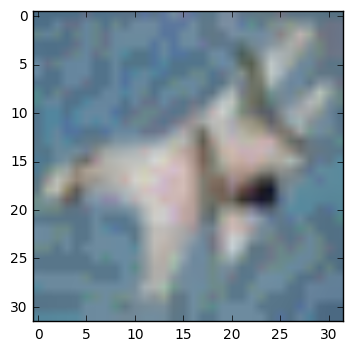

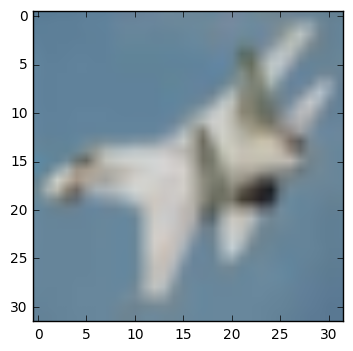

In [11]:
X_stab = X_test + 0.04*numpy.sign(stab_gradient)
X_stab /= X_stab.max()
i = 10
plt.imshow(numpy.reshape(X_stab[i], [32,32,3]))
plt.show()
plt.imshow(numpy.reshape(X_test[i], [32,32,3]))

## Accuracy Computation for fixed perturbation
We compute accuracy of each for $\epsilon=0.001$

In [12]:
eps = 0.001
X_stab = X_test + eps*numpy.sign(stab_gradient)
X_stab /= X_stab.max()
X_class = X_test + eps*numpy.sign(class_gradient)
X_class /= X_class.max()

In [14]:
class_acc = class_net.test(X_class, y_test)
print("Classicly trained network accuracy: %f"%class_acc)
stab_acc = stab_net.test(X_stab, y_test)
print("Stability trained network accuracy: %f"%stab_acc)

Classicly trained network accuracy: 0.757200
Stability trained network accuracy: 0.756400


Performances are slightly lower for stabilized network...

## Accuracy curve for varying $\epsilon$
We compute accuracies for different values of $\epsilon$

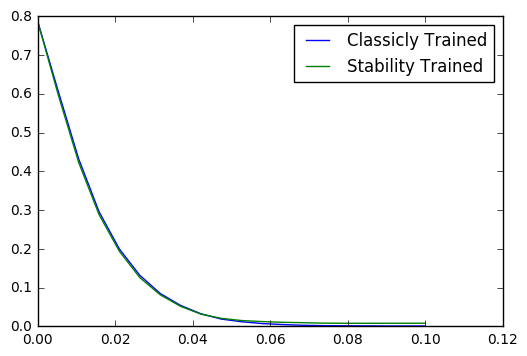

In [15]:
epsilons = numpy.linspace(0.0001, 0.1, 20)
accuracies = numpy.zeros([2,epsilons.shape[0]])
for epsiter in range(0,epsilons.shape[0]):
    X_stab = X_test.copy() + epsilons[epsiter]*numpy.sign(stab_gradient)
    X_stab /= X_stab.max()
    X_class = X_test.copy() + epsilons[epsiter]*numpy.sign(class_gradient)
    X_class /= X_class.max()
    accuracies[0,epsiter] = class_net.test(X_class, y_test)
    accuracies[1,epsiter] = stab_net.test(X_stab, y_test)
plt.plot(epsilons,accuracies[0], label='Classicly Trained')
plt.plot(epsilons,accuracies[1], label='Stability Trained')
plt.legend()
plt.savefig('Figures/accuracy_curv.pdf')

Again, stabilized network gives the same performances as classic network

## Top-n Accuracies curve for fixed $\epsilon$
We compute the __top-n__ accuracies for $n\in [1,10]$

CPU times: user 5min 12s, sys: 59.6 s, total: 6min 11s
Wall time: 3min 44s


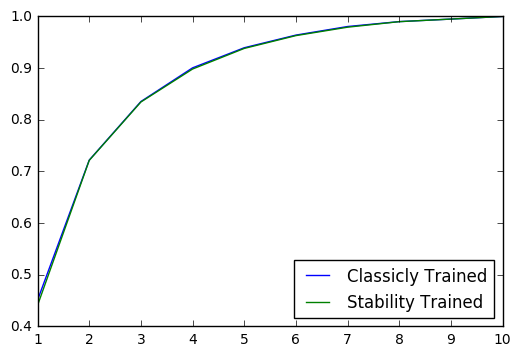

In [16]:
%%time
top_ns = numpy.arange(1,11)
accuracies = numpy.zeros([2, top_ns.shape[0]])
eps = 0.01
X_stab = X_test.copy() + eps*numpy.sign(stab_gradient)
X_stab /= X_stab.max()
X_class = X_test.copy() + eps*numpy.sign(class_gradient)
X_class /= X_class.max()

for itr in range(0,top_ns.shape[0]):
    accuracies[0,itr] = class_net.test(X_class, y_test, top=top_ns[itr])
    accuracies[1,itr] = stab_net.test(X_stab, y_test, top=top_ns[itr])
    
plt.plot(top_ns,accuracies[0], label='Classicly Trained')
plt.plot(top_ns,accuracies[1], label='Stability Trained')
plt.legend(loc=4)
plt.savefig('Figures/top_n.pdf')

Again, the stabilized training seem to give no particular behavior